# **Aplicaciones Financieras de ML & AI**
## **Examen II:** *Objetos Financieros Parte I*

#### Nombre: Julio César Avila Torreblanca

- **Problema 1:**:
    1. Descargue datos del precio del dólar en pesos mexicanos, use Yahoo Finance.
    2. Proponer una red de arquitectura LSTM que realice una predicción (forecast)
de la serie de tiempo anterior. ¿Es posible mejorar los resultados de un modelo ARIMA?
    3. ¿Es posible utilizar redes neuronales recurrentes en lugar de un modelo
ARCH?, Intente implementarlo y observe los resultados.


- **Contenido del notebook**:
    1. Librerías y parámetros
    2. Lectura de los datos
    3. Forecasting con ARIMA
    4. Forecasting con GARCH
    5. Forecasting con LSTM
    6. Conclusiones



# 1. Librerías y parámetros

In [2]:
!pip install arch arch

In [25]:
# data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import yfinance as yf

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# modeling
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model

import tensorflow as tf
from tensorflow import keras


# 2. Lectura de los datos

In [5]:
data = yf.download(
        tickers = "MXN=X", # dollar price
        period = "1y", # one year information
        interval = "1d", # daily information
    ).loc[:, 'Close']

data = data.rename(columns={'MXN=X': 'dollar_price'})
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,dollar_price
Date,
2024-04-04,16.527000
2024-04-05,16.573200
2024-04-08,16.452000
2024-04-09,16.314301
2024-04-10,16.383310
...,...
2025-04-01,20.474030
2025-04-02,20.328341
2025-04-03,20.258301


# 3. Forecasting con ARIMA
Los pasos a seguir son:
- Validar si la serie de tiempo es estacionaria, caso contrario, transformar los datos.
- Obtener los valores de p,q
- Entrenar las combinaciones $ARIMA(p,d,q)$
- Seleccionar el mejor modelo
- Análisis de resultados

## 3.1 *Estacionalidad*

In [6]:
# uso de test Dickey-Fuller para ver si la st es estacionaria
ADF_result = adfuller(data['dollar_price'])

print('ADF test con los datos originales:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los datos originales:
-> ADF Statistic: -1.8149703263850325
-> p-value: 0.3730550781771602


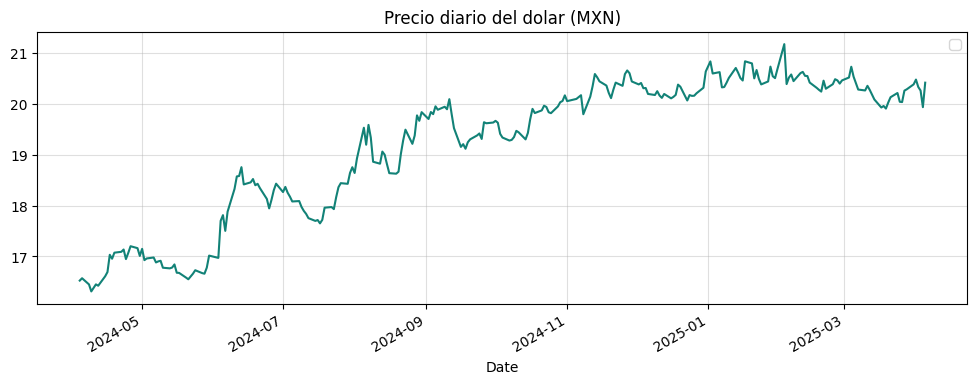

In [7]:
data['dollar_price'].plot(
    figsize = (12,4),
    color='#128277'
)

plt.title("Precio diario del dolar (MXN)")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Dado que p-value > 0.05 no se rechaza la hipótesis nula, por ende la serie de tiempo no es estacionaria.

Probaremos con los retornos logaritmicos.

In [8]:
data['log_returns'] = np.log(data['dollar_price']) - np.log(data['dollar_price'].shift(1))
data = data.dropna()

ADF_result = adfuller(data['log_returns'])

print('ADF test con los retornos logarítmicos:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los retornos logarítmicos:
-> ADF Statistic: -12.668103579937222
-> p-value: 1.261812238413855e-23


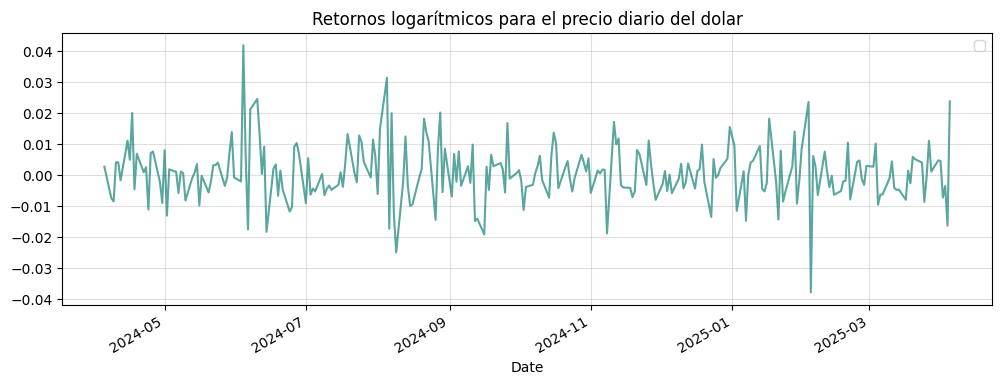

In [9]:
data['log_returns'].plot(
    figsize = (12,4),
    color='#128277',
    alpha=0.7
)

plt.title("Retornos logarítmicos para el precio diario del dolar")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Aquí p-value < 0.05, por lo que tomando los retornos logarítmicos del dolar obtenemos una serie de tiempo estacionaria. Trabajaremos con esta.

## 3.2 Obtener $p$, $q$

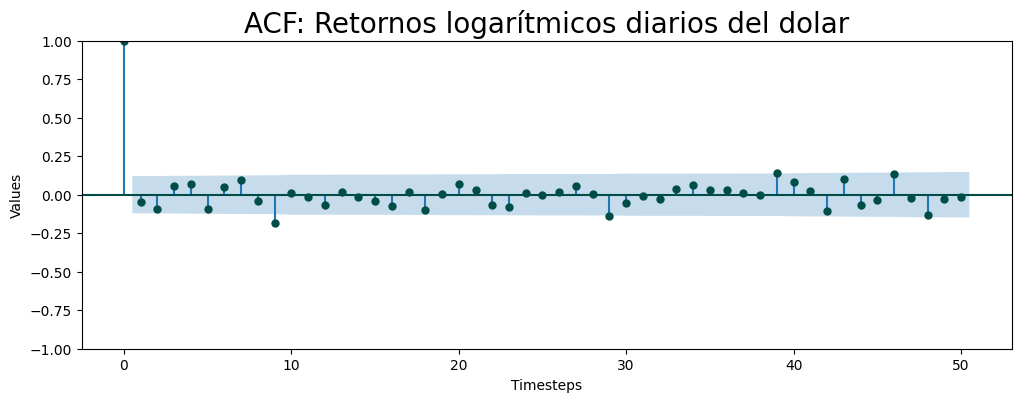

In [10]:
# ACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_acf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'ACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

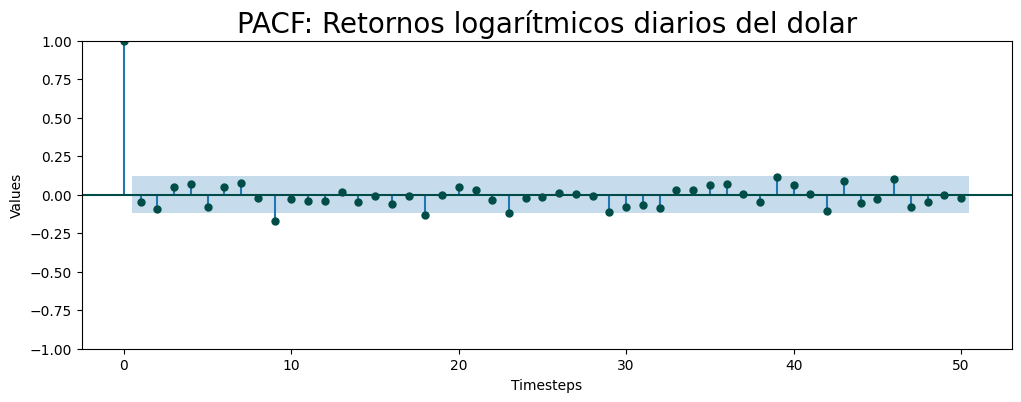

In [11]:
# PACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_pacf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'PACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

Analizando los gráficos de ACP y PACF, vemos que solo la serie de tiempo solo tiene autocorrleación con el primer lag, con el resto de valores pasados no se aprecia alguna correlación. Dada la falta de Autocorrelaciones, podemos suponer que el uso del modelo ARIMA puede que no nos llegue a realizar una buena predicción. Por ahora continuaremos con el ejercicio tomando $p,q=1$.

## 3.3 Modelo ARIMA

### Split data
Tomaremos el último **mes** como test y entrenaremos con el resto de datos.

In [13]:
train_data = data.iloc[:-20,:].copy()
test_data = data.iloc[-20:,:].copy()

print(train_data.shape)
print(test_data.shape)

(241, 2)
(20, 2)


### Train

In [26]:
# MODELO ARIMA
model_arma = ARIMA(
    train_data['log_returns'],
    order=(1, 0, 1),
    enforce_stationarity=False,
)

model_arma.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
print(model_arma.summary())

AttributeError: 'ARIMA' object has no attribute 'summary'

### Test

In [20]:
test_data['predict'] = model_arma.predict(steps=20)

TypeError: Model.predict() missing 1 required positional argument: 'params'